## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import os
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Calibrate the Camera

In [3]:
# prepare object points
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

nx = 9  # the number of inside corners in x
ny = 6  # the number of inside corners in y

objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y coordinates

# read in images and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

for fname in images: 
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
#         cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         plt.imshow(img)

    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

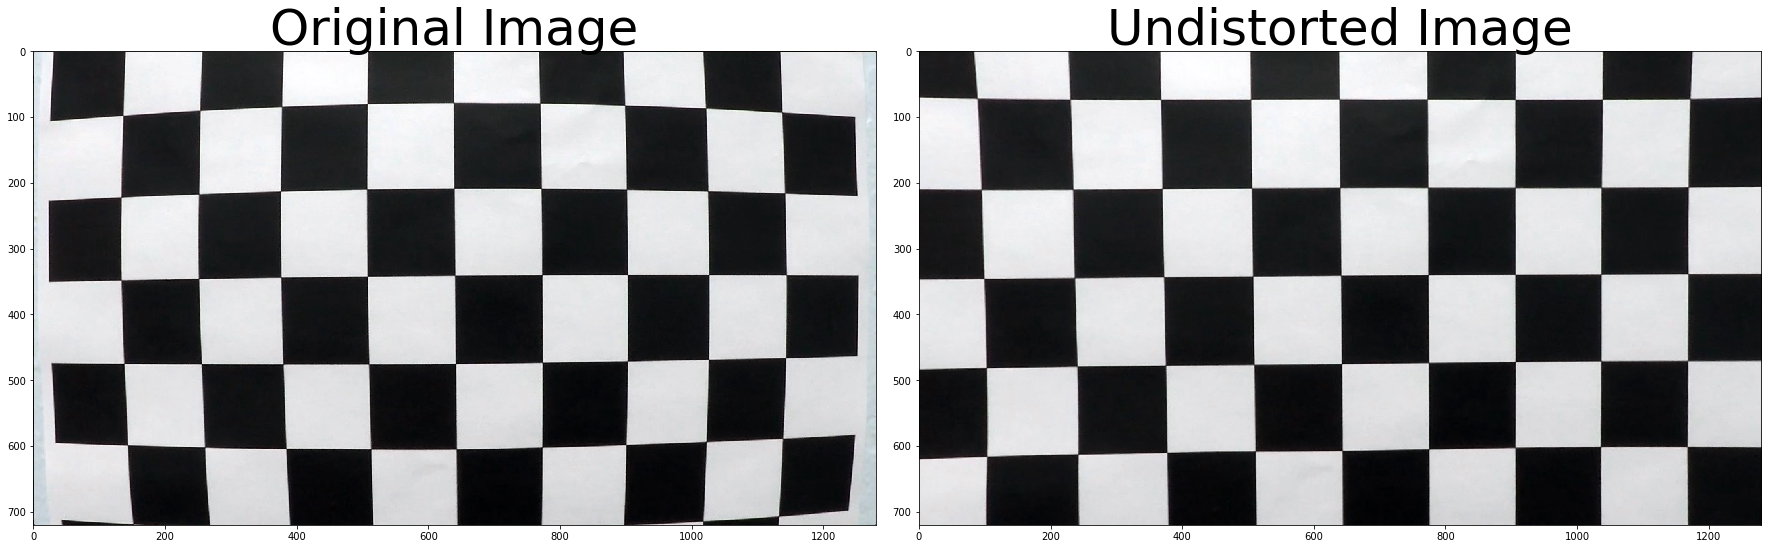

In [4]:
#undistort an image
img = cv2.imread('./camera_cal/calibration1.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort and Transform Perspective

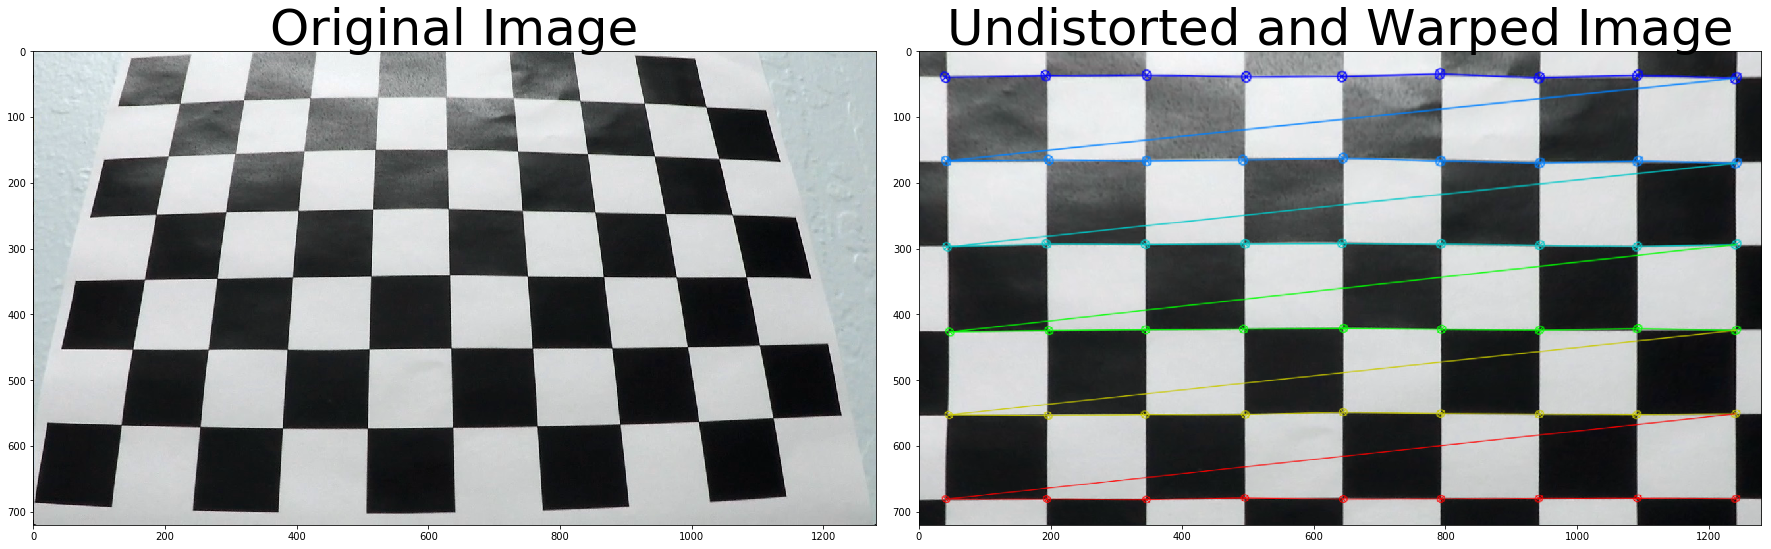

In [4]:
### Undistort and Transform Perspective


def corners_unwarp(img, nx, ny, mtx, dist):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(corners)
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 40 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst,src)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
        
    return warped, M, Minv

# Read in an image
img = cv2.imread('./camera_cal/calibration3.jpg')

top_down, perspective_M, Minv = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Create the Perspective view - BirdEye view

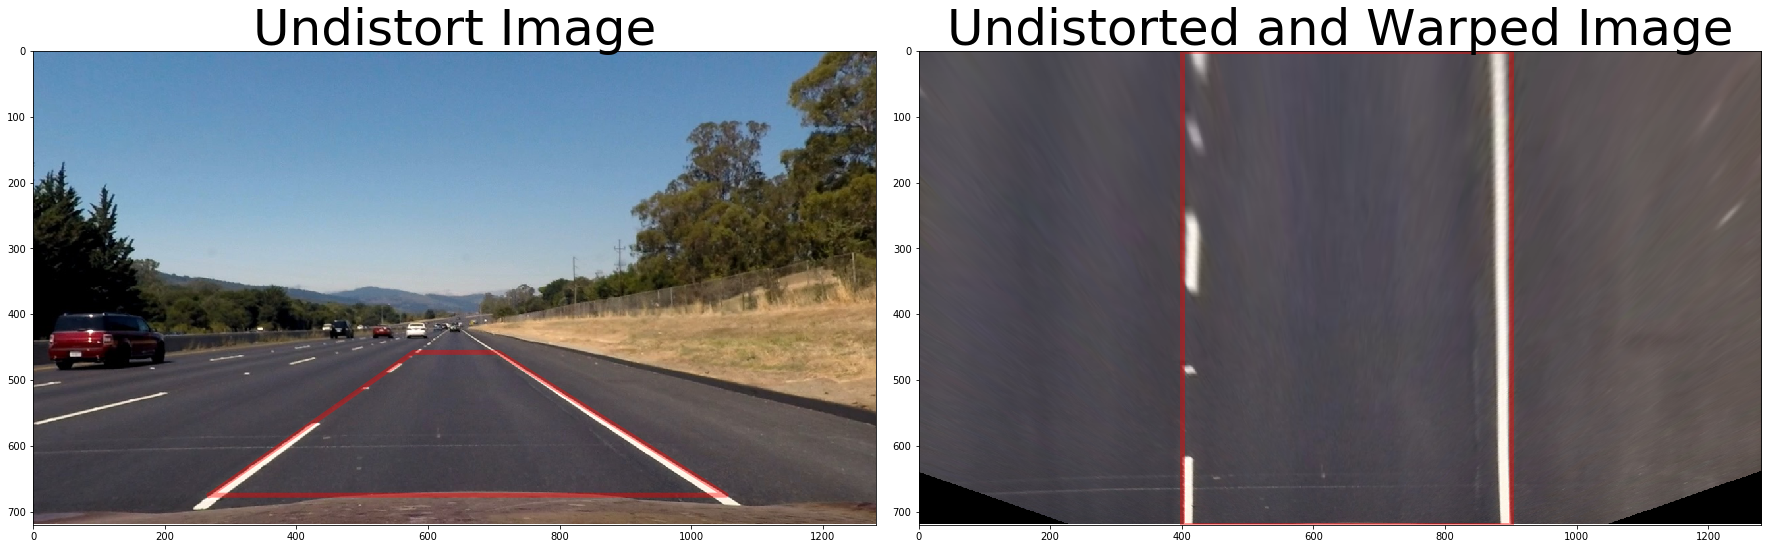

In [23]:
# Read in an image
img = mpimg.imread('./test_images/straight_lines2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

# plt.imshow(undist)

# For source points I'm grabbing the outer four detected corners
src = np.float32([[268,675], [1053,675], [578,458], [707,458]])
dst = np.float32([[400,720],[900,720],[400,0],[900,0]])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist, M, (1280,720))
h,w = warped.shape[:2]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=5)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistort Image', fontsize=50)
ax2.imshow(warped)
x1 = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y1 = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x1, y1, color='red', alpha=0.4, linewidth=5)
ax2.set_ylim([h,0])
ax2.set_xlim([0,w])
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Threshold Functions

Below are some threshold functions to get started. 

In [6]:
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0, ksize=sobel_kernel)
    if orient=='y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary


# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return mag_binary


# Define a function that applies Sobel x and y,
# then computes the direction of the gradient and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(sobelx**2)
    abs_sobely = np.sqrt(sobely**2)
    gradient = np.arctan2(abs_sobely,abs_sobelx)
    dir_binary = np.zeros_like(gradient)
    dir_binary[(gradient>thresh[0]) & (gradient<thresh[1])]=1
    return dir_binary


def hls_Sthreshold(img,thresh=(50,255)):
    hls_S = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,2]
    binary = np.zeros_like(hls_S)
    binary[(hls_S>thresh[0]) & (hls_S<thresh[1])] = 1
    return binary

def hls_Lthreshold(img, thresh=(220, 255)):
    hls_L = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,1]
    binary = np.zeros_like(hls_L)
    binary[(hls_L>thresh[0]) & (hls_L<thresh[1])] = 1
    return binary


def rgb_Rthreshold(img,thresh=(100,255)):
    rgb_R = img[:,:,0]
    binary = np.zeros_like(rgb_R)
    binary[(rgb_R>thresh[0]) & (rgb_R<thresh[1])] = 1
    return binary

Check different thresholding functions effect on finding lane pixels 

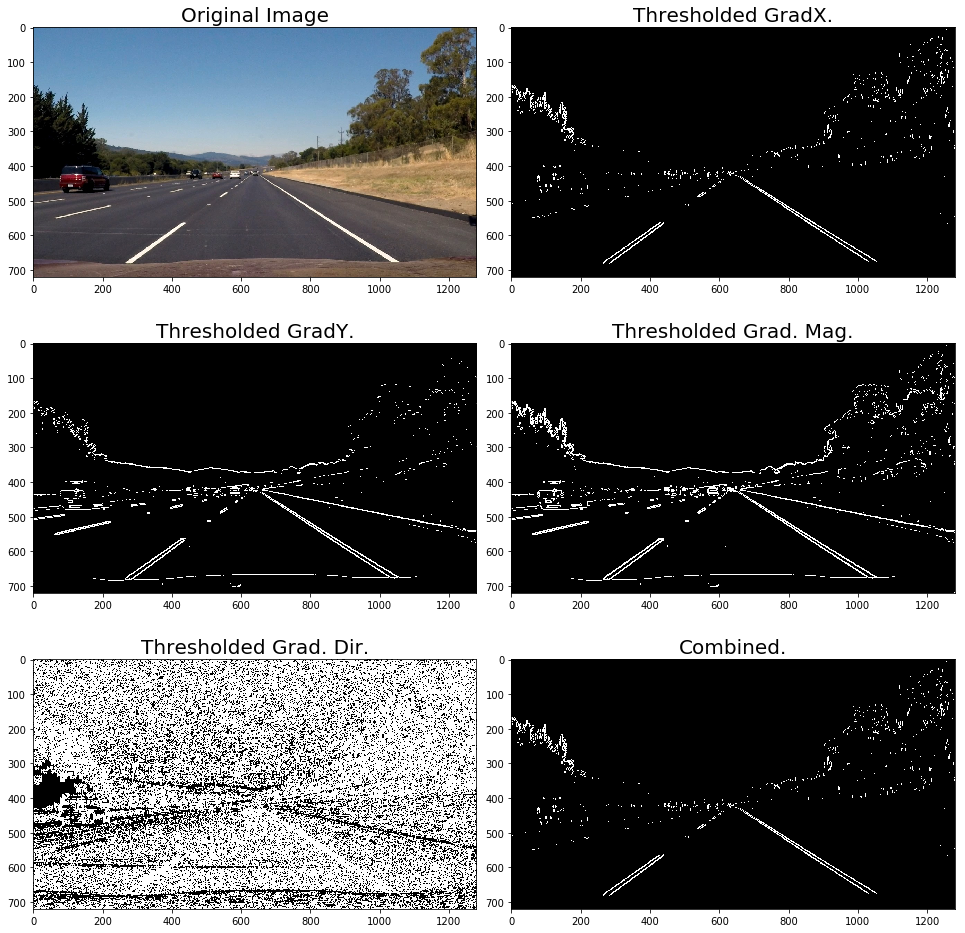

In [12]:
# Read in an image
image = img     #mpimg.imread('./test_images/test3.jpg')

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (dir_binary==1)) ] = 1


# Plot the result
f, ax = plt.subplots(3, 2, figsize=(16,16))
ax = ax.ravel()
f.tight_layout()
ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('Thresholded GradX.', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('Thresholded GradY.', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Thresholded Grad. Mag.', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Thresholded Grad. Dir.', fontsize=20)
ax[5].imshow(combined, cmap='gray')
ax[5].set_title('Combined.', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()


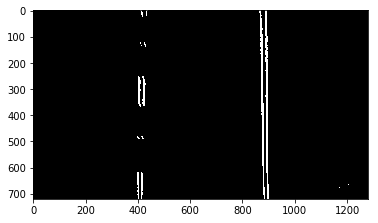

In [14]:
image = warped  
# hls_S = hls_Sthreshold(image)
# rgb_R = rgb_Rthreshold(image)

# combined = np.zeros_like(rgb_R)
# combined[((rgb_R == 1) & (hls_S == 1)) ] = 1

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (dir_binary==1)) ] = 1

plt.imshow(combined,cmap='gray')

## Naming conventions
#### leftx,lefty,rightx,righty are original left right lane pixel positions
#### left_fit, right_fit  are 1x3 array contain the 2nd order polynomial parameters
#### left_fitx, right_fitx are the fitted lines' x positions, ploty is the fitted line y positions

## sliding window method
find_lane_pixels searches the lane pixels by using sliding window method.

In [24]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the warped image (only the ROI road info)
    histogram = np.sum(binary_warped[:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 3)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 3)

        #Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


In [44]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    #Fit a second order polynomial to each using `np.polyfit`
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img,ploty,left_fitx,right_fitx,left_fit,right_fit


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


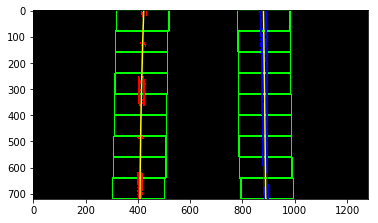

In [28]:
result,ploty,left_fitx,right_fitx,left_fit,right_fit = fit_polynomial(combined/255)
plt.imshow(result)
# mpimg.imsave("output_images/slidingWindowPolyfit.png",result,format='png')

## Search around last poly fit
search_around_poly finds lane pixels and fit new polynomial based on last frame fit data.

In [43]:
def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values 
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    img_shape = binary_warped.shape
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    #Calc both polynomials using ploty, left_fit and right_fit 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return out_img,ploty,left_fitx,right_fitx,left_fit,right_fit


### Measure the curvature of the road

In [31]:
def measure_curvature(binary_warped,ploty,left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 feet = 3.048m
    xm_per_pix = 3.7/500 # meters per pixel in x dimension, lane width is 12 feet = 3.7m
    
    # Fit a second order polynomial to pixel positions in each lane line
    ##### Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    return left_curverad, right_curverad

### Measure the vehicle's offset from the center of the road

In [32]:
def measure_center_offset(binary_warped,left_fit,right_fit):
    #center offset is image midpoint subtract the average of l_fit and r_fit intercepts
    xm_per_pix = 3.7/500 # meters per pixel in x dimension, lane width is 12 feet = 3.7m
    height,width = binary_warped.shape
      
    l_fit_x = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    r_fit_x = right_fit[0]*height**2 + right_fit[1]*height + right_fitx[2]
    
    lane_center_position = (r_fit_x + l_fit_x) /2
    car_position = width/2
    pixel_offset = car_position - lane_center_position
    center_offset = pixel_offset * xm_per_pix
    
    return center_offset

## Draw drivable area

In [33]:
#draw drivable area
def drawDriveArea(img, binary_warped, ploty, left_fit, right_fit, Minv):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_warped.shape
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

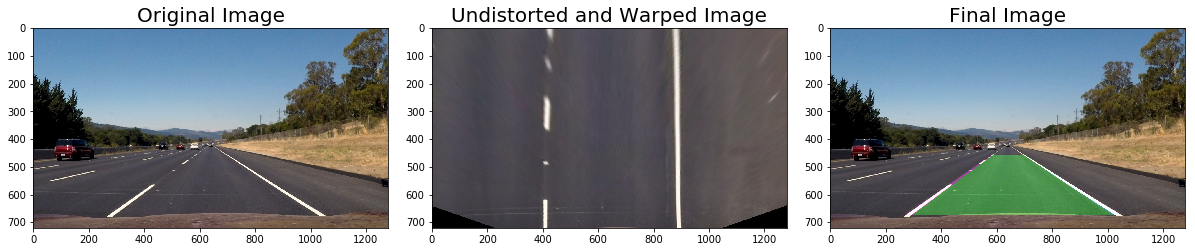

In [34]:
result=drawDriveArea(img, combined, ploty, left_fit, right_fit, Minv)

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=20)
ax3.imshow(result)
ax3.set_title('Final Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [37]:
#output the curvature and center offset data to the output image/video

def output_data(img, curvature, center_offset):
    h = img.shape[0]
    new_img = np.copy(img)
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curvature) + 'm.'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'
    abs_center_dist = abs(center_offset)
    text = 'The car is ' + '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of the road center.'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

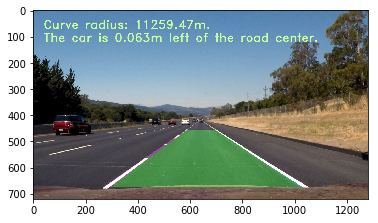

In [38]:
curve1,curve2 = measure_curvature(combined,ploty,left_fit,right_fit)
center_offset = measure_center_offset(combined,left_fit,right_fit)
curve = (curve1+curve2)/2
final_img = output_data(result, curve, center_offset)
plt.imshow(final_img)

## Test Images

Build the pipeline to work on the images in the directory "test_images"  
**Make sure the pipeline works well on these images before trying the videos.**

In [25]:
import os
for imageName in os.listdir("test_images/"):

    file = "test_images/"+imageName
#     file = "test_images/"+"test6.jpg"
    img = mpimg.imread(file)

    # undistort the image
    undistort = cv2.undistort(img, mtx, dist, None, mtx);  

    # warp the image
    warped = cv2.warpPerspective(undistort, M, (1280,720))

    # create the binary image by applying gradiant/dir/mag HLS/RGB thresholds

    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0, 1.3))

    warped_binary = np.zeros_like(dir_binary)
    warped_binary[((gradx == 1) & (dir_binary==1)) ] = 1


    #detect lane lines and fit polynomial on the binary image 
    fit_poly_img,ploty,left_fitx,right_fitx,left_fit,right_fit = fit_polynomial(warped_binary/255)
    # plt.imshow(result)

    # measure center offset and curvatures
    center_offset = measure_center_offset(warped_binary,left_fit,right_fit)
    curve1,curve2 = measure_curvature(warped_binary,ploty,left_fit,right_fit)
    curve = (curve1+curve2)/2
    # 
    img_drive_area=drawDriveArea(img, warped_binary, ploty, left_fit, right_fit, Minv)

    final_img = output_data(img_drive_area, curve, center_offset)



    #mpimg.imsave("output_images/"+imageName,final_img,format='jpg')
    # plt.imshow(final_img)

## Define a class to receive the characteristics of each line detection

In [39]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  


    def add_fit(self, fit):
        # add a found fit to the line, up to 4
        num2keep = 8
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares to the best_fit
                self.diffs = abs(fit-self.best_fit)
                if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.):
                    # bad fit! dump it
                    self.detected = False
                else:
                    if  (len(self.current_fit) > 0):
                        self.detected = True
                        self.current_fit.append(fit)
                        if len(self.current_fit) > num2keep:
                            # throw out old fits, keep newest num2keep
                            self.current_fit = self.current_fit[len(self.current_fit)-num2keep:]
                        self.best_fit = np.average(self.current_fit, axis=0)
            else:
                #get rid of the first dummy data in current_fit,and assign best_fit
                self.detected = True
                self.current_fit.append(fit)
                self.current_fit = self.current_fit[len(self.current_fit)-1:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # if not found, remove one from the history, 
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
#                 self.current_fit = self.current_fit[:len(self.current_fit)-1]
#                 if len(self.current_fit) > 0:
#                     # if there are still any fits in the queue, best_fit is their average
#                     self.best_fit = np.average(self.current_fit, axis=0)
                self.current_fit = self.current_fit[len(self.current_fit)-1:]
                self.best_fit = np.average(self.current_fit, axis=0)



## Build a Lane Finding Pipeline



In [40]:
def preprocess(img):
    # undistort the image
    undistort = cv2.undistort(img, mtx, dist, None, mtx);  

    # warp the image
    warped = cv2.warpPerspective(undistort, M, (1280,720))

    # create the binary image by applying gradiant/dir/mag HLS/RGB thresholds

    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (dir_binary==1)) ] = 1
    
    return combined

In [41]:
def process_image(image):
    new_img = np.copy(image)
    warped_binary = preprocess(new_img)
    
    # if both left and right lanes were detected last frame, use search_around_poly, otherwise use fit_polynomial
    if not left_lane.detected or not right_lane.detected:
        result,ploty,left_fitx,right_fitx,left_fit,right_fit = fit_polynomial(warped_binary) 
    else:
        result,ploty,left_fitx,right_fitx,left_fit,right_fit = search_around_poly(warped_binary,left_lane.best_fit,right_lane.best_fit)
        
    # discard the fits if the lane width is not around 500 px (+/- 50 px)
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        lane_width_top = abs(left_fitx[0]-right_fitx[0])
        lane_width_down = abs(left_fitx[-1]-right_fitx[-1])
        
        if (abs(500 - abs(lane_width_top)) > 100) or (abs(500 - abs(lane_width_down)) > 100):
            left_fit = None
            right_fit = None
            
    left_lane.add_fit(left_fit)
    right_lane.add_fit(right_fit)
    
    # draw the current best fit if it exists
    if left_lane.best_fit is not None and left_lane.best_fit is not None:
        img_out = drawDriveArea(new_img, warped_binary,ploty, left_lane.best_fit, right_lane.best_fit, Minv)
        curve1,curve2 = measure_curvature(warped_binary,ploty,left_lane.best_fit, right_lane.best_fit)
        center_offset = measure_center_offset(warped_binary, left_lane.best_fit, right_lane.best_fit)
        final_img = output_data(img_out, (curve1+curve2)/2, center_offset)
    else:
        final_img = new_img

    return final_img

## Test on Videos



In [45]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip

left_lane = Line()
right_lane = Line()
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')#.subclip(25,35)
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video project_video_output1.mp4
[MoviePy] Writing video project_video_output1.mp4



 12%|█▏        | 152/1261 [00:25<03:09,  5.85it/s]


 24%|██▍       | 303/1261 [00:53<02:49,  5.66it/s]


 36%|███▌      | 454/1261 [01:19<02:21,  5.69it/s]


 48%|████▊     | 605/1261 [01:46<01:55,  5.68it/s]


 60%|█████▉    | 756/1261 [02:14<01:29,  5.63it/s]


 72%|███████▏  | 907/1261 [02:40<01:02,  5.63it/s]


 84%|████████▍ | 1057/1261 [03:07<00:36,  5.62it/s]


 96%|█████████▌| 1205/1261 [03:34<00:09,  5.61it/s]


100%|█████████▉| 1260/1261 [03:45<00:00,  5.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output1.mp4 

CPU times: user 12min 40s, sys: 1.89 s, total: 12min 42s
Wall time: 3min 45s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
